In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import seaborn as sns
import yfinance as yf

In [38]:
efts_data = pd.read_csv("../data/etf_data.csv", index_col=0, parse_dates=True)  #
spy_data = efts_data['SPY']

vix_data = yf.download('^VIX', start="2019-01-01", end="2024-12-31", auto_adjust=False)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [39]:
df = pd.DataFrame()
df['SPY'] = spy_data
df['VIX'] = vix_data
df.dropna(inplace=True)

# Log returns
df['SPY_return'] = np.log(df['SPY'] / df['SPY'].shift(1))
df['VIX_return'] = np.log(df['VIX'] / df['VIX'].shift(1))
df.dropna(inplace=True)


##### Hidden Markov Model (HMM)

In [40]:
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, random_state=42)
hmm_model.fit(df[['SPY_return', 'VIX_return']])
df['Regime'] = hmm_model.predict(df[['SPY_return', 'VIX_return']])

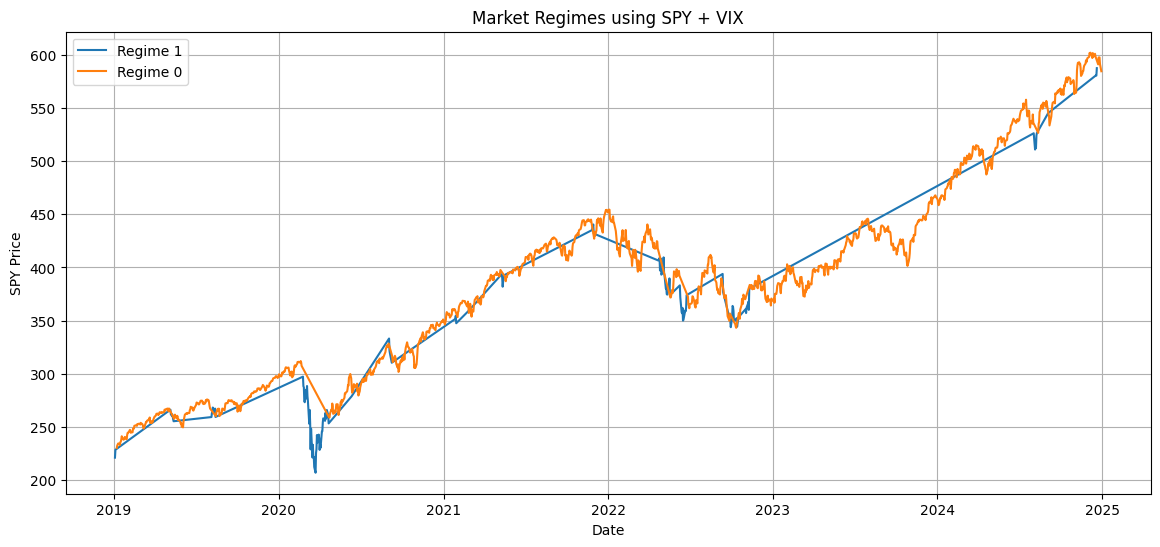

In [41]:
plt.figure(figsize=(14, 6))
for reg in df['Regime'].unique():
    plt.plot(df[df['Regime'] == reg].index, df[df['Regime'] == reg]['SPY'], label=f'Regime {reg}')
plt.title("Market Regimes using SPY + VIX")
plt.xlabel("Date")
plt.ylabel("SPY Price")
plt.legend()
plt.grid()
plt.show()


In [42]:
df[['Regime']].to_csv("../data/market_regime.csv")

In [43]:
market_regimes = pd.read_csv("../data/market_regime.csv", index_col=0, parse_dates=True)

etf_columns = ['GLD', 'IWM', 'QQQ', 'SPY', 'TLT', 'XLE', 'XLF', 'XLK']

for etf in etf_columns:
    etf_df = pd.DataFrame()
    etf_df[etf] = efts_data[etf]
    etf_df = etf_df.join(market_regimes, how='inner')
    etf_df.to_csv(f"../data/{etf}_with_regime.csv")


### Regime 0 :- Steady growth, low volatility. AKA Bull Market.
### Regime 1 :- Falling prices, high volatility. AKA Bear Market.

In [45]:
import pandas as pd

# Load AAPL with merged regime
aapl = pd.read_csv("../data/AAPL_with_regimes.csv", index_col=0, parse_dates=True)

# Calculate log returns if not done already
if 'log_return' not in aapl.columns:
    aapl['log_return'] = np.log(aapl['AAPL'] / aapl['AAPL'].shift(1))
    aapl.dropna(inplace=True)


In [46]:
for regime in sorted(aapl['Regime'].unique()):
    subset = aapl[aapl['Regime'] == regime]
    mean_return = subset['log_return'].mean()
    volatility = subset['log_return'].std()
    
    print(f"\n📊 Regime {regime}")
    print(f"  ▶️ Mean Return: {mean_return:.6f}")
    print(f"  ⚡ Volatility  : {volatility:.6f}")


📊 Regime 0
  ▶️ Mean Return: -0.000396
  ⚡ Volatility  : 0.031851

📊 Regime 1
  ▶️ Mean Return: 0.001705
  ⚡ Volatility  : 0.013043


In [47]:
def analyze_regime(etf_name: str):
    df = pd.read_csv(f"../data/{etf_name}_with_regime.csv", index_col=0, parse_dates=True)
    df['log_return'] = np.log(df[etf_name] / df[etf_name].shift(1))
    df.dropna(inplace=True)

    print(f"\n📈 Regime Analysis for {etf_name}")
    for regime in sorted(df['Regime'].unique()):
        mask = df['Regime'] == regime
        mean_ret = df[mask]['log_return'].mean()
        vol = df[mask]['log_return'].std()
        print(f"  🔹 Regime {regime}: Mean = {mean_ret:.6f}, Volatility = {vol:.6f}")

In [48]:
analyze_regime("QQQ")
analyze_regime("XLK")


📈 Regime Analysis for QQQ
  🔹 Regime 0: Mean = 0.001459, Volatility = 0.012066
  🔹 Regime 1: Mean = -0.005538, Volatility = 0.033749

📈 Regime Analysis for XLK
  🔹 Regime 0: Mean = 0.001584, Volatility = 0.012930
  🔹 Regime 1: Mean = -0.005588, Volatility = 0.037611
